In [ ]:
! pip install gym
! pip install highway-env

In [58]:
import gym
import highway_env
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import random
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import pygame
import imageio
from IPython.display import HTML
from matplotlib import animation
import pandas as pd
from scipy.stats import norm , t
from scipy.stats import ttest_ind
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import warnings
warnings.filterwarnings('ignore')

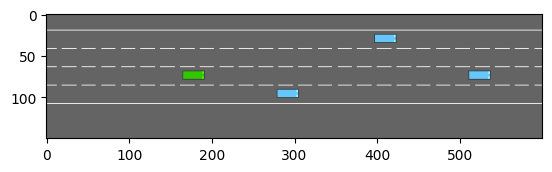

In [59]:
plt.style.use('default')
os.environ["SDL_VIDEODRIVER"] = "dummy"
env = gym.make('highway-v0', render_mode='rgb_array')
env.reset()
env.render()
os.environ['SDL_VIDEODRIVER'] = "x11"
env = gym.make('highway-v0', render_mode='rgb_array')
env.reset()
plt.imshow(env.render());
plt.style.use('ggplot')

In [60]:
env = gym.make('highway-v0', render_mode='rgb_array')
print('State shape: ', env.observation_space.shape)
print('\nNumber of actions: ', env.action_space.n)
print('\nState sample: \n', env.observation_space.sample())

State shape:  (5, 5)

Number of actions:  5

State sample: 
 [[ 0.45717335 -1.1673336   1.2713618   1.4612398   0.7726104 ]
 [ 0.09054755 -1.2794892  -1.3973104   0.97921383  1.1062616 ]
 [ 0.30328044  2.7626212  -2.470957   -0.31356987  0.66942316]
 [-0.20971993 -0.6863307   0.17060937  0.07022897 -0.85439813]
 [ 0.05261944 -0.08044812 -0.0401025   0.20522411 -1.1564974 ]]


In [5]:
#@title Hyperparameters


In [6]:
#@title Saving the renders as gifs

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    imageio.mimwrite(os.path.join(path, filename), frames, fps=15)


## Agent

In [54]:
#@title Network
import torch 
import torch.nn as nn
import torch.nn.functional as F

class DeepNetwork(nn.Module):
    def __init__(self, state_size, action_size,seed):
        super(DeepNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return self.fc4(x)

class CNN(nn.Module):
    def __init__(self, state_size, action_size,seed):
        super(CNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(3,128,kernel_size = 3)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*128, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, action_size)
        
    def forward(self, state):
        x = self.conv1(state)
        x = F.relu(x)
        x = self.conv2
        x = F.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return self.fc4(x)


In [8]:
#@title Buffer
import numpy as np
import random
import torch
from collections import deque, namedtuple
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [9]:
#@title DQN_agent
import random
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque, namedtuple
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Agent():
    def __init__(self, state_size, action_size, seed, buffer_size = 1e5):
        self.batch_size = 64
        self.gamma = 0.99
        self.tau = 1e-3
        self.update_freq = 4     
        self.alpha = 5e-4        
        self.buffer_size = int(buffer_size)
        self.seed = random.seed(seed)
        self.state_size = state_size
        self.action_size = action_size

        self.qnetwork_local = DeepNetwork(state_size, action_size,seed).to(device)
        self.qnetwork_target = DeepNetwork(state_size, action_size,seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.alpha)

        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_freq

        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
          if(np.argmax(action_values.cpu().data.numpy()) > 4):
            return random.choice(np.arange(self.action_size))
          else:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def act_with_updated_values(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action_values = self.qnetwork_local(state)
        if(np.argmax(action_values.cpu().data.numpy()) > 4):
            return random.choice(np.arange(self.action_size))
        else:
            return np.argmax(action_values.cpu().data.numpy())

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(q_expected, q_targets)
        # loss = nn.MSELoss()(q_expected,q_targets.view(1, -1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau )                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



In [31]:
#@title DQCNN_agent
import random
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque, namedtuple
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Agent_CNN():
    def __init__(self, state_size, action_size, seed, buffer_size = 1e5):
        self.batch_size = 64
        self.gamma = 0.99
        self.tau = 1e-3
        self.update_freq = 4     
        self.alpha = 5e-4        
        self.buffer_size = int(buffer_size)
        self.seed = random.seed(seed)
        self.state_size = state_size
        self.action_size = action_size

        self.qnetwork_local = CNN(state_size, action_size,seed).to(device)
        self.qnetwork_target = CNN(state_size, action_size,seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.alpha)

        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_freq

        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
          if(np.argmax(action_values.cpu().data.numpy()) > 4):
            return random.choice(np.arange(self.action_size))
          else:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def act_with_updated_values(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action_values = self.qnetwork_local(state)
        if(np.argmax(action_values.cpu().data.numpy()) > 4):
            return random.choice(np.arange(self.action_size))
        else:
            return np.argmax(action_values.cpu().data.numpy())

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(q_expected, q_targets)
        # loss = nn.MSELoss()(q_expected,q_targets.view(1, -1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau )                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [10]:
#@title Agent_Trainer

class Train_Agent():
  def __init__(self,env,agent,Episodes,Repeats,Epsilon_policy):
    self.env = env
    self.agent = agent
    self.Episodes = Episodes
    self.Repeats = Repeats
    self.agent_scores = []
    self.frames = []
    self.max_t = 1000000

  def train(self):
    eps_start = 1.0
    eps_end = 0.001
    eps_decay = 0.995

    for r in range(1,self.Repeats+1):
      scores = []
      ts = []
      eps = eps_start
      for i_episode in range(1, self.Episodes+1):
          state , info = self.env.reset()
          score = 0
          for t in range(self.max_t):
              action = self.agent.act(state.ravel(), eps)
              next_state, reward, done, truncated, info = self.env.step(action)
              self.agent.step(state.ravel(), action, reward, next_state.ravel(), done)
              state = next_state
              score += reward
              if done or truncated:
                  break
          scores.append(score)
          ts.append(t)
          eps = max(eps_end, eps_decay*eps)

          print('\rEpisode {}\tAverage Score: {:.1f}\tnumber of steps = {}'.format(i_episode,np.mean(scores),t), end="")

          if i_episode % self.Episodes == 0:
                    torch.save(self.agent.qnetwork_local.state_dict(), './local_weights')
                    torch.save(self.agent.qnetwork_target.state_dict(), './target_weights')

      self.agent_scores.append(scores)
    return self.agent_scores,ts

  def Evaluate_current_Network(self,test_episodes):
    scores = []
    for i_episode in range(1, test_episodes+1):
        state,info = self.env.reset()
        score = 0
        for t in range(self.max_t):
            action = self.agent.act_with_updated_values(state.flatten())
            next_state, reward, done, truncated, info = self.env.step(action)
            frame = env.render()
            self.frames.append(frame)
            state = next_state
            score += reward
            if done or truncated:
                break
        scores.append(score)
    return self.frames


In [11]:
#@title Transfer Learning Agent Trainer

class Train_Transfer_Learning_Agent():
  def __init__(self,env,agent,Episodes,Repeats,Epsilon_policy,weights_path1,weights_path2):
    self.env = env
    self.agent = agent
    self.Episodes = Episodes
    self.Repeats = Repeats
    self.weights_path1 = weights_path1
    self.weights_path2 = weights_path2
    self.agent_scores = []
    self.frames = []
    self.max_t = 1000000

  def train(self):
    eps_start = 1.0
    eps_end = 0.001
    eps_decay = 0.995

    self.agent.qnetwork_local.load_state_dict(torch.load(self.weights_path1))
    self.agent.qnetwork_target.load_state_dict(torch.load(self.weights_path2))

    for r in range(1,self.Repeats+1):
      scores = []
      ts = []
      eps = eps_start
      for i_episode in range(1, self.Episodes+1):
          state , info = self.env.reset()
          score = 0
          for t in range(self.max_t):
              action = self.agent.act(state.ravel(), eps)
              next_state, reward, done, truncated, info = self.env.step(action)
              self.agent.step(state.ravel(), action, reward, next_state.ravel(), done)
              state = next_state
              score += reward
              if done or truncated:
                  break
          scores.append(score)
          ts.append(t)
          eps = max(eps_end, eps_decay*eps)

          print('\rEpisode {}\tAverage Score: {:.1f}\tnumber of steps = {}'.format(i_episode,np.mean(scores),t), end="")


      self.agent_scores.append(scores)
    return self.agent_scores,ts

  def Evaluate_current_Network(self,test_episodes):
    scores = []
    for i_episode in range(1, test_episodes+1):
        state,info = self.env.reset()
        score = 0
        for t in range(self.max_t):
            action = self.agent.act_with_updated_values(state.flatten())
            next_state, reward, done, truncated, info = self.env.step(action)
            frame = env.render()
            self.frames.append(frame)
            state = next_state
            score += reward
            if done or truncated:
                break
        scores.append(score)
    return self.frames

In [25]:
#@title Plot results

def plot_results(agent_scores,window_size,figure,ax,label):

  n_rep, n_episode = np.array(agent_scores).shape
  smoothed_agent_scores = []
  for i in range(n_rep):
    smoothed_agent_scores.append(pd.Series(agent_scores[i]).rolling(window_size , min_periods = 0).mean())

  x_bar = np.mean(np.array(smoothed_agent_scores), axis=0) 
  sigma = np.std(np.array(smoothed_agent_scores), axis=0) 
  SE = sigma / np.sqrt(n_rep)
  interval =  1 - 0.3
  if n_rep < 30:
      t_statistic = t.interval(interval, df = n_rep - 1)[1]
      ME = t_statistic * SE
  else:
      z_statistic = norm.interval(interval)[1]
      ME = z_statistic * SE        

  ax.plot(range(0,n_episode), x_bar , label = label)
  if n_rep >= 2:
      ax.fill_between(range(0,n_episode), (x_bar - ME), (x_bar + ME), alpha=0.05)
  ax.set_xlabel("Episodes", fontsize=13)
  ax.set_ylabel("Average reward", fontsize=13)
  ax.legend()


## Part 1

In [ ]:
env = gym.make('merge-v0',render_mode = 'rgb_array')
agent = Agent(state_size=25, action_size=5,seed = 810198367 , buffer_size=1e3)
TA = Train_Agent(env,agent,2000,5,0)
agent_scores , steps = TA.train()

Episode 2000	Average Score: 13.1	number of steps = 15

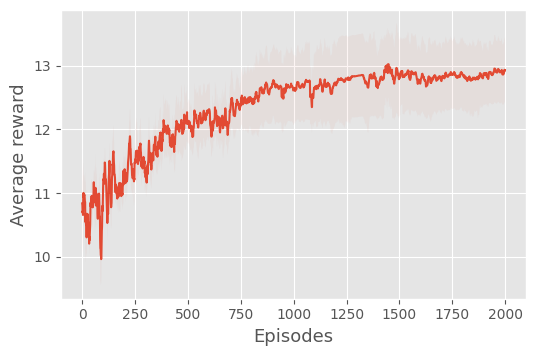

In [ ]:
plot_results(agent_scores)

### Rendering The Merge-v0 Environment

In [29]:
env = gym.make('merge-v0',render_mode = 'rgb_array')
agent = Agent(state_size=25, action_size=5,seed = 810198367 , buffer_size=1e5)
TA = Train_Agent(env,agent,1500,1,0)
agent_scores , steps = TA.train()

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episode 1500	Average Score: 11.0	number of steps = 11

In [30]:
frames = TA.Evaluate_current_Network(10)

In [31]:
save_frames_as_gif(frames, path='./', filename='merge_animation.gif')

## Part 2

### Fast Highway without merge weights

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


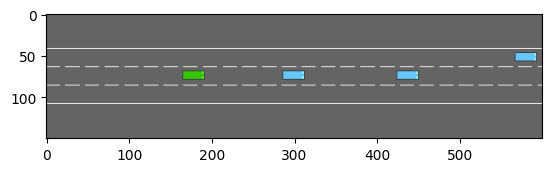

In [13]:
plt.style.use('default')
os.environ["SDL_VIDEODRIVER"] = "dummy"
env = gym.make('highway-fast-v0', render_mode='rgb_array')
env.reset()
env.render()
os.environ['SDL_VIDEODRIVER'] = "x11"
env = gym.make('highway-fast-v0', render_mode='rgb_array')
env.reset()
plt.imshow(env.render());
plt.style.use('ggplot')

In [14]:
env = gym.make('highway-fast-v0', render_mode='rgb_array')
agent = Agent(state_size=25, action_size=5,seed = 810198367 , buffer_size=1e3)
TA_hwf = Train_Agent(env , agent ,1500,1,0)
agent_scores_hwf , steps = TA_hwf.train()

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episode 1500	Average Score: 8.2	number of steps = 11

In [16]:
frames = TA_hwf.Evaluate_current_Network(1)

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In [17]:
save_frames_as_gif(frames, path='./', filename='Fast_Highway_animation.gif')

### Fast Highway with merge weights

In [18]:
env = gym.make('merge-v0',render_mode = 'rgb_array')
agent = Agent(state_size=25, action_size=5,seed = 810198367 , buffer_size=1e5)
TA = Train_Agent(env,agent,1500,1,0)
agent_scores , steps = TA.train()

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episode 1500	Average Score: 11.0	number of steps = 11

In [19]:
env1 = gym.make('highway-fast-v0',render_mode = 'rgb_array')
agent1 = Agent(state_size=25, action_size=5,seed = 810198367 , buffer_size=1e5)
TA_TL = Train_Transfer_Learning_Agent(env1,agent1,1500,1,0,'./local_weights','./target_weights')
agent_scores_TA_TL , steps = TA_TL.train()

Episode 1500	Average Score: 17.5	number of steps = 29

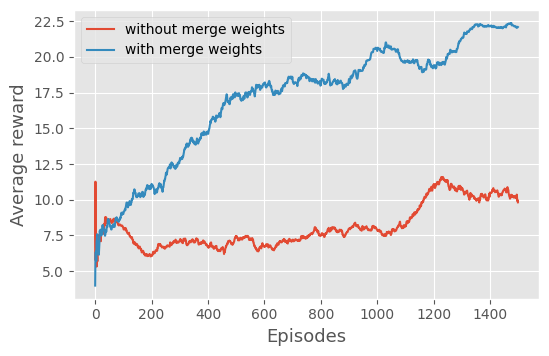

In [26]:
fig, ax = plt.subplots(figsize = (6, 3.75))
plot_results(agent_scores_hwf,100,fig,ax,'without merge weights')
plot_results(agent_scores_TA_TL,100,fig,ax,'with merge weights')

## Part 3

### DQN with Image Observation

In [50]:
class Image_Observerer_Training_Agent():
  def __init__(self,env,agent,Episodes,Repeats,Epsilon_policy):
    self.env = env
    self.agent = agent
    self.Episodes = Episodes
    self.Repeats = Repeats
    self.agent_scores = []
    self.frames = []
    self.max_t = 1000000

  def train(self):
    eps_start = 1.0
    eps_end = 0.001
    eps_decay = 0.995

    for r in range(1,self.Repeats+1):
      scores = []
      ts = []
      eps = eps_start
      for i_episode in range(1, self.Episodes+1):
          _ , _ = self.env.reset()
          previous_image = self.change_image_size(self.env.render())
          current_image = self.change_image_size(self.env.render())

          observation = current_image - previous_image

          score = 0
          for t in range(self.max_t):
              action = self.agent.act(observation, eps)
              _, reward, done, truncated, _ = self.env.step(action)
              previous_image = current_image
              current_image = self.change_image_size(self.env.render())
              next_observation = current_image - previous_image
              self.agent.step(observation, action, reward, next_observation, done)
              observation = next_observation
              score += reward
              if done or truncated:
                  break
          scores.append(score)
          ts.append(t)
          eps = max(eps_end, eps_decay*eps)

          print('\rEpisode {}\tAverage Score: {:.1f}\tnumber of steps = {}'.format(i_episode,np.mean(scores),t), end="")

          if i_episode % self.Episodes == 0:
                    torch.save(self.agent.qnetwork_local.state_dict(), './local_weights')
                    torch.save(self.agent.qnetwork_target.state_dict(), './target_weights')

      self.agent_scores.append(scores)
    return self.agent_scores,ts

  def Evaluate_current_Network(self,test_episodes):
    scores = []
    for i_episode in range(1, test_episodes+1):
        state,info = self.env.reset()
        score = 0
        for t in range(self.max_t):
            action = self.agent.act_with_updated_values(state.flatten())
            next_state, reward, done, truncated, info = self.env.step(action)
            frame = env.render()
            self.frames.append(frame)
            state = next_state
            score += reward
            if done or truncated:
                break
        scores.append(score)
    return self.frames

  def change_image_size(self, image):
        image = np.ascontiguousarray(image, dtype=np.float32) / 255
        image = torch.from_numpy(image)
        image = image.permute(2,0,1)
        return image.numpy()

In [ ]:
env = gym.make('merge-v0',render_mode = 'rgb_array')
agent = Agent_CNN(state_size=25, action_size=5,seed = 810198367 , buffer_size=1e5)
TA_IO = Image_Observerer_Training_Agent(env,agent,1500,1,0)
agent_scores_IO , steps = TA_IO.train()